### Welch's two-sample $t$-test

The goal of Welch's two-sample $t$-test to check if the means two unknown population $X \sim \mathcal{N}(\mu_X, \sigma_X)$ and $Y \sim \mathcal{N}(\mu_Y, \sigma_Y)$
are the same or different.

We previously discussed this hypothesis test in [notebooks/35_two_sample_tests.ipynb](../notebooks/35_two_sample_tests.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

#### Data
Two samples of numerical observations $\mathbf{x}=[x_1, x_2, \ldots, x_n]$
and $\mathbf{y}=[y_1, y_2,\ldots, y_m]$ from independent populations.

#### Modeling assumptions

We assume the unknown populations are normally distributed $\textbf{(NORM)}$,
or the sample is large enough $\textbf{(LARGEn)}$.

#### Hypotheses

$H_0: \mu_X = \mu_Y$ and $H_A: \mu_X \neq \mu_Y$.

#### Statistical design

for $n=5$ ...


for $n=20$ ...


#### Estimates

Compute the sample means
$\overline{\mathbf{x}} = \Mean(\mathbf{x})$,
$\overline{\mathbf{y}} = \Mean(\mathbf{y})$,
and the difference between means
$\hat{d} = \DMeans(\mathbf{x}, \mathbf{y}) = \overline{\mathbf{x}} - \overline{\mathbf{y}}$.

#### Formulas
The estimated standard error of the difference between means estimator is

$$
  \stderrhat{\hat{d}}
        \; = \; \sqrt{  \stderrhat{\overline{\mathbf{x}}}^2 + \stderrhat{\overline{\mathbf{y}}}^2 }
        = \sqrt{ \tfrac{s_{\mathbf{x}}^2}{n} + \tfrac{s_{\mathbf{y}}^2}{m} },
$$

where $s_{\mathbf{x}}$ and $s_{\mathbf{y}}$ are the sample standard deviations.

#### Test statistic

Compute the $t$-statistic $t = \frac{\hat{d} - 0}{ \stderrhat{\hat{d}} }$.

#### Sampling distribution

Student's $t$-distribution with $\nu_d$ degrees of freedom,
where the degrees of freedom parameter is computed using
the helper function `calcdf`:
$\nu_d = \tt{calcdf}(s_{\mathbf{x}}, n, s_{\mathbf{y}}, m)$,
which implements the Welch--Satterthwaite formula.

#### P-value calculation

In [3]:
from stats_helpers import ttest_dmeans

%psource ttest_dmeans

def ttest_dmeans(xsample, ysample, equal_var=False, alt="two-sided"):
    """
    T-test to detect difference between two populations means
    based on the difference between sample means.
    """
    # Calculate the observed difference between means
    obsdhat = mean(xsample) - mean(ysample)

    # Calculate the sample sizes and the stds
    n, m = len(xsample), len(ysample)
    sx, sy = std(xsample), std(ysample)

    # Calculate the standard error, the degrees of
    # freedom, the null model, and the t-statistic
    if not equal_var:  # Welch's t-test (default)
        seD = np.sqrt(sx**2/n + sy**2/m)
        obst = (obsdhat - 0) / seD
        dfD = calcdf(sx, n, sy, m)
        rvT0 = tdist(df=dfD)
    else:              # Use pooled variance
        varp = ((n-1)*sx**2 + (m-1)*sy**2) / (n+m-2)
        stdp = np.sqrt(varp)
        seDp = stdp * np.sqrt(1/n + 1/m)
        obst = (obsdhat - 0) / seDp
        dfp = n + m - 2
        rvT0 = tdist(df=dfp)

    # Calculate the p-value 

To perform the two-sample $t$-test on the samples `xs` and `ys`,
we call `ttest_dmeans(xs, ys)`.

#### Examples

For all the examples we present below,
we assume the unknown distribution are normally distributed 

$$
    \texttt{rvX} = X \sim \mathcal{N}(\mu_X,\sigma_X)
    \qquad
    \text{and}
    \qquad
    \texttt{rvY} = Y \sim \mathcal{N}(\mu_Y,\sigma_Y).
$$


In [4]:
from scipy.stats import norm

##### Example A: populations are different

Suppose the $X$-population is normally distributed 
with mean $\mu_{X}=104$
and standard deviation $\sigma_{X} = 3$,
while the $Y$-population is normally distributed 
with mean $\mu_{X}=100$
and standard deviation $\sigma_{X} = 5$

$$
    \texttt{rvX} = X \sim \mathcal{N}(104,3)
    \qquad
    \text{and}
    \qquad
    \texttt{rvY} = Y \sim \mathcal{N}(100,5).
$$

In [5]:
muXA = 104
sigmaXA = 3
rvXA = norm(muXA, sigmaXA)

muYA = 100
sigmaYA = 5
rvYA = norm(muYA, sigmaYA)

Let's generate a sample `xAs` and `yAs` of size $n=20$ from the random variables $X = \texttt{rvXA}$ and $Y = \texttt{rvYA}$.

In [6]:
np.random.seed(42)

# generate a random sample of size n=20 from rvX
n = 20
xAs = rvXA.rvs(n)

# generate a random sample of size m=20 from rvY
m = 20
yAs = rvYA.rvs(m)
xAs, yAs

(array([105.49014246, 103.5852071 , 105.94306561, 108.56908957,
        103.29753988, 103.29758913, 108.73763845, 106.30230419,
        102.59157684, 105.62768013, 102.60974692, 102.60281074,
        104.72588681,  98.26015927,  98.8252465 , 102.31313741,
        100.96150664, 104.942742  , 101.27592777,  99.7630889 ]),
 array([107.32824384,  98.8711185 , 100.33764102,  92.87625907,
         97.27808638, 100.55461295,  94.24503211, 101.87849009,
         96.99680655,  98.54153125,  96.99146694, 109.26139092,
         99.93251388,  94.71144536, 104.11272456,  93.89578175,
        101.04431798,  90.20164938,  93.35906976, 100.98430618]))

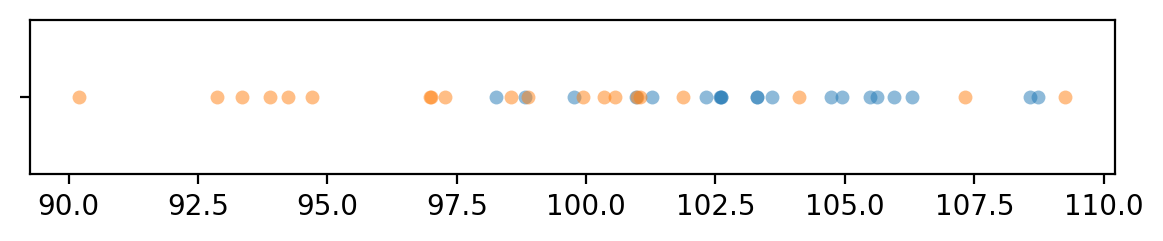

In [7]:
import seaborn as sns

with plt.rc_context({"figure.figsize":(7,1)}):
    sns.stripplot(x=xAs, jitter=0, alpha=0.5)
    sns.stripplot(x=yAs, jitter=0, alpha=0.5)

To obtain the $p$-value,
we first compute the observed $t$-statistic,
then calculate the tail probabilities in the two tails of the standard normal distribution $T_0 \sim \mathcal{T}(\nu_d)$.

In [17]:
from scipy.stats import t as tdist
from stats_helpers import calcdf

# Calculate the sample statistics
from stats_helpers import mean, std
obsdhat = mean(xAs) - mean(yAs)
sx, sy = std(xAs), std(yAs)

# Calculate the standard error and the t-statistic
seD = np.sqrt(sx**2/n + sy**2/m)
obst = (obsdhat - 0) / seD

# Calculate the degrees of freedom
dfD = calcdf(sx, n, sy, m)

rvT0 = tdist(df=dfD)
pvalue = rvT0.cdf(-obst) + 1-rvT0.cdf(obst)
obsdhat, pvalue

(4.815979892644748, 0.0005953205918275417)

The helper function `ttest_dmeans` in the `stats_helpers` module performs
exactly the same sequence of steps to compute the $p$-value.

In [9]:
from stats_helpers import ttest_dmeans
ttest_dmeans(xAs, yAs)

0.0005953205918276521

The $p$-value we obtain is 0.000595,
which is below the cutoff value $\alpha=0.05$,
so our conclusion is **we reject the null hypothesis**:
the difference between the means of the two unknown populations is statistically significant.

##### Example B: sample from a population as expected under $H_0$

In [10]:
muXB = 100
sigmaXB = 5
rvXB = norm(muXB, sigmaXB)

muYB = muXB
sigmaYB = sigmaXB
rvYB = norm(muYB, sigmaYB)

Let's generate a sample `xs` of size $n=20$ from the random variable $X = \texttt{rvX}$,
which has the same distribution as the theoretical distribution we expect under the null hypothesis.

In [11]:
# np.random.seed(32)  produces false positie
np.random.seed(31)

# generate a random sample of size n=20 from rvX
n = 20
xBs = rvXB.rvs(n)

# generate a random sample of size m=20 from rvY
m = 20
yBs = rvYB.rvs(m)
# xBs, yBs

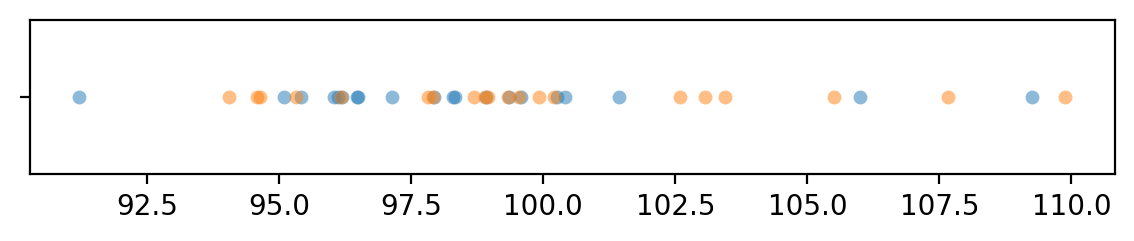

In [12]:
import seaborn as sns
with plt.rc_context({"figure.figsize":(7,1)}):
    sns.stripplot(x=xBs, jitter=0, alpha=0.5)
    sns.stripplot(x=yBs, jitter=0, alpha=0.5)

In [13]:
from stats_helpers import ttest_dmeans
ttest_dmeans(xBs, yBs)

0.28673199738563526

The $p$-value we obtain is 0.28, which is above the cutoff value $\alpha=0.05$
so our conclusion is that we've **failed to reject the null hypothesis**:
the means of two samples are not significantly different.

#### Confidence interval for the effect size

In [14]:
from stats_helpers import ci_dmeans

The confidence interval for the effect size $\Delta = \mu_X - \mu_Y$ in Example A is

In [15]:
ci_dmeans(xAs, yAs, alpha=0.1, method='a')

[2.6805293784320785, 6.951430406857417]

The confidence interval for the effect size $\Delta = \mu_X - \mu_Y$ in Example B is

In [16]:
ci_dmeans(xBs, yBs, alpha=0.1, method='a')

[-3.6180594963139185, 0.7920428862020961]

#### Related



#### Discussion

#### Links

### Bonus example: Lalonde dataset

see original paper https://business.baylor.edu/scott_cunningham/teaching/lalonde-1986.pdf  
and these links for more info: https://www.one-tab.com/page/h_npVXMeTp2T7Dm5fAlDqw


In [2]:
import pandas as pd
lalonde = pd.read_csv("../datasets/lalonde.csv")
lalonde

,ID,Training,Age,Education_years,Married,No_Degree,Wage_1974,Wage_1975,Wage_1978
0,0,False,23,10,0,1,0.00,0.00,0.000
1,1,False,26,12,0,0,0.00,0.00,12383.680
2,2,False,22,9,0,1,0.00,0.00,0.000
3,3,False,18,9,0,1,0.00,0.00,10740.080
4,4,False,45,11,0,1,0.00,0.00,11796.470
...,...,...,...,...,...,...,...,...,...
440,440,True,33,12,1,0,20279.95,10941.35,15952.600
441,441,True,25,14,1,0,35040.07,11536.57,36646.950
442,442,True,35,9,1,1,13602.43,13830.64,12803.970
443,443,True,35,8,1,1,13732.07,17976.15,3786.628


In [4]:
control = lalonde[lalonde["Training"]==False]
treated = lalonde[lalonde["Training"]==True]

In [19]:
control.describe()

,ID,Age,Education_years,Married,No_Degree,Wage_1974,Wage_1975,Wage_1978
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,129.500000,25.053846,10.088462,0.153846,0.834615,2107.026658,1266.909002,4554.801126
std,75.199734,7.057745,1.614325,0.361497,0.372244,5687.905694,3102.982044,5483.835991
min,0.000000,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64.750000,19.000000,9.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,129.500000,24.000000,10.000000,0.000000,1.000000,0.000000,0.000000,3138.795500
75%,194.250000,28.000000,11.000000,0.000000,1.000000,139.424700,650.096475,7288.420000
max,259.000000,55.000000,14.000000,1.000000,1.000000,39570.680000,23031.980000,39483.530000


In [8]:
treated.describe()

,ID,Age,Education_years,Married,No_Degree,Wage_1974,Wage_1975,Wage_1978
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,352.000000,25.816216,10.345946,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,53.549043,7.155019,2.010650,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,260.000000,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,306.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,352.000000,25.000000,11.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,398.000000,29.000000,12.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,444.000000,48.000000,16.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [17]:
from scipy.stats import ttest_ind

ttest_ind(treated["Wage_1978"], control["Wage_1978"], equal_var=False)

Ttest_indResult(statistic=2.674145513783345, pvalue=0.007892977714517335)

In [23]:
from stats_helpers import cohend2

cohend2(treated["Wage_1978"], control["Wage_1978"])

0.27271540735846456